## **PREDICTING THE IDEAL LOCATION FOR OPENNING A SPA CENTRE IN SINGAPORE**

### **LOAD DATA FROM IBM DB CLOUD BY USING SQL MAGIC**

In [11]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [12]:
%sql ibm_db_sa://dcg13641:7wds%5Eqtlbbpvkl5m@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB

'Connected: dcg13641@BLUDB'

In [4]:
data = %sql select * from Retail

 * ibm_db_sa://dcg13641:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


In [13]:
data = %sql select * from Retail
df = data.DataFrame()
df.head()

 * ibm_db_sa://dcg13641:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


,Street,Median_Rent____psm__per_month_
0,AIRPORT BOULEVARD,270.63
1,ALEXANDRA ROAD,102.91
2,ANG MO KIO AVENUE 3,303.79
3,ANSON ROAD,75.36
4,BALESTIER ROAD,76.67


### **INSTALL GEOGY AND FIND THE LAT AND LONG FOR EACH LOCATION IN COLUMN STREET**

In [4]:
pip install geopy

     |████████████████████████████████| 122kB 5.9MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [14]:
df['Street'] = df['Street'] + ', sg'
df.head()

,Street,Median_Rent____psm__per_month_
0,"AIRPORT BOULEVARD, sg",270.63
1,"ALEXANDRA ROAD, sg",102.91
2,"ANG MO KIO AVENUE 3, sg",303.79
3,"ANSON ROAD, sg",75.36
4,"BALESTIER ROAD, sg",76.67


In [15]:
geolocator = Nominatim()
df['gcode'] = df['Street'].apply(geolocator.geocode)
df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


,Street,Median_Rent____psm__per_month_,gcode
0,"AIRPORT BOULEVARD, sg",270.63,"(Airport Boulevard, Changi, Southeast, 207663,..."
1,"ALEXANDRA ROAD, sg",102.91,"(Alexandra Road, Bukit Merah, Singapore, Centr..."
2,"ANG MO KIO AVENUE 3, sg",303.79,"(Ang Mo Kio Avenue 3, Ang Mo Kio, Singapore, C..."
3,"ANSON ROAD, sg",75.36,"(Anson Road, Radin Mas, Bukit Merah, Singapore..."
4,"BALESTIER ROAD, sg",76.67,"(Balestier Road, Novena, Singapore, Central, 3..."


In [16]:
df['lat'] = [g.latitude for g in df.gcode]
df['long'] = [g.longitude for g in df.gcode]
df.head()

,Street,Median_Rent____psm__per_month_,gcode,lat,long
0,"AIRPORT BOULEVARD, sg",270.63,"(Airport Boulevard, Changi, Southeast, 207663,...",1.358623,103.989130
1,"ALEXANDRA ROAD, sg",102.91,"(Alexandra Road, Bukit Merah, Singapore, Centr...",1.283903,103.801557
2,"ANG MO KIO AVENUE 3, sg",303.79,"(Ang Mo Kio Avenue 3, Ang Mo Kio, Singapore, C...",1.369781,103.838831
3,"ANSON ROAD, sg",75.36,"(Anson Road, Radin Mas, Bukit Merah, Singapore...",1.271805,103.843321
4,"BALESTIER ROAD, sg",76.67,"(Balestier Road, Novena, Singapore, Central, 3...",1.322346,103.852741


### Define Foursquare Credentials and Version

In [17]:
CLIENT_ID = 'FPURLTN0HP4EJMMJQLQRBPK1UGEBPPFFKENYJSCUEPFSKCR5' # your Foursquare ID
CLIENT_SECRET = 'AH4B4BY31VLEI2ZF3G3YNGSFUL3UDQ1KZ5I2JXAJ3JUJRMDM' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FPURLTN0HP4EJMMJQLQRBPK1UGEBPPFFKENYJSCUEPFSKCR5
CLIENT_SECRET:AH4B4BY31VLEI2ZF3G3YNGSFUL3UDQ1KZ5I2JXAJ3JUJRMDM


In [18]:
neighborhood_latitude = df.loc[0, 'lat']
neighborhood_longitude = df.loc[0, 'long'] 

neighborhood_name = df.loc[0, 'Street'] 

### **GET THE NEAYBY VENEU FOR THE FIRST LOCATION IN COLUMN STREET**

In [19]:
LIMIT= 100
radius=500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=FPURLTN0HP4EJMMJQLQRBPK1UGEBPPFFKENYJSCUEPFSKCR5&client_secret=AH4B4BY31VLEI2ZF3G3YNGSFUL3UDQ1KZ5I2JXAJ3JUJRMDM&v=20180604&ll=1.3586234,103.9891295&radius=500&limit=100'

In [20]:
results = requests.get(url).json()

In [21]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)


filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]


nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)


nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Jewel Changi Airport,Shopping Mall,1.360119,103.989790
1,HSBC Rain Vortex,Waterfall,1.360151,103.989740
2,Birds Of Paradise,Ice Cream Shop,1.360363,103.989088
3,Crowne Plaza Changi Airport,Hotel,1.358561,103.987967
4,Tim Ho Wan,Dim Sum Restaurant,1.360219,103.989151


### **REPEAT THE SAME PROCESS FOR ALL THE LOCATIONS IN THE DATAFRAME**

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
Street_venues = getNearbyVenues(names=df['Street'],
                                   latitudes=df['lat'],
                                   longitudes=df['long']
                                  )

AIRPORT BOULEVARD, sg
ALEXANDRA ROAD, sg
ANG MO KIO AVENUE 3, sg
ANSON ROAD, sg
BALESTIER ROAD, sg
BAYFRONT AVENUE, sg
BEACH ROAD, sg
BENCOOLEN STREET, sg
BUKIT TIMAH ROAD, sg
CHANGI BUSINESS PARK CENTRAL 1, sg
CHANGI ROAD, sg
CHOA CHU KANG AVENUE 4, sg
CHOA CHU KANG NORTH 6, sg
CLEMENCEAU AVENUE, sg
COLEMAN STREET, sg
COLLYER QUAY, sg
COMMONWEALTH AVENUE WEST, sg
CUPPAGE ROAD, sg
CUSCADEN ROAD, sg
EAST COAST ROAD, sg
EU TONG SEN STREET, sg
GEYLANG ROAD, sg
GOPENG STREET, sg
GUILLEMARD ROAD, sg
HAVELOCK ROAD, sg
HIGH STREET, sg
HOLLAND AVENUE, sg
HOUGANG AVENUE 10, sg
HOUGANG STREET 51, sg
IRRAWADDY ROAD, sg
JALAN ANAK BUKIT, sg
JALAN BERSEH, sg
JALAN BESAR, sg
JALAN JURONG KECHIL, sg
JALAN MASJID, sg
JELEBU ROAD, sg
JURONG EAST STREET 21, sg
JURONG GATEWAY ROAD, sg
JURONG WEST CENTRAL 2, sg
JURONG WEST CENTRAL 3, sg
KITCHENER ROAD, sg
KOEK ROAD, sg
LORONG KILAT, sg
MACPHERSON ROAD, sg
MARINA BOULEVARD, sg
MARINE PARADE ROAD, sg
MARITIME SQUARE, sg
MIDDLE ROAD, sg
MOUNTBATTEN ROAD, sg


In [28]:
Street_onehot = pd.get_dummies(Street_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Street_onehot['Neighborhood'] = Street_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [Street_onehot.columns[-1]] + list(Street_onehot.columns[:-1])
Street_onehot = Street_onehot[fixed_columns]

Street_onehot.head()

,Yoga Studio,ATM,Accessories Store,Airport Lounge,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Court,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Canal,Candy Store,Cantonese Restaurant,Casino,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Stadium,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Laundromat,Leather Goods Store,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mosque,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Train

### **Group the results by Neighborhood and show the Venue occurance frequency**

In [29]:
Street_grouped = Street_onehot.groupby('Neighborhood').mean().reset_index()
Street_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,Airport Lounge,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Court,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Canal,Candy Store,Cantonese Restaurant,Casino,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Stadium,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Laundromat,Leather Goods Store,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mosque,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Train

### **Find The Top 30 most common Venue for each Location**

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 30

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Street_grouped['Neighborhood']

for ind in np.arange(Street_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Street_grouped.iloc[ind, :], num_top_venues)

In [32]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
0,"AIRPORT BOULEVARD, sg",Airport Lounge,Boutique,Public Art,Sandwich Place,Candy Store,Ice Cream Shop,Smoke Shop,General Entertainment,Border Crossing,Garden,Bubble Tea Shop,Spa,Burger Joint,Snack Place,Shoe Store,Multiplex,Shopping Mall,Supermarket,Food Court,Café,Fast Food Restaurant,Cocktail Bar,Coffee Shop,Electronics Store,Gift Shop,Dim Sum Restaurant,Bakery,Hobby Shop,Waterfall,Hotel
1,"ALEXANDRA ROAD, sg",Chinese Restaurant,Juice Bar,Bakery,Satay Restaurant,Soup Place,Fast Food Restaurant,Sporting Goods Shop,Bridge,Thai Restaurant,Seafood Restaurant,Asian Restaurant,Food Court,Dumpling Restaurant,Flea Market,Fish & Chips Shop,Fishing Spot,Women's Store,Flower Shop,Food,Filipino Restaurant,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Food & Drink Shop,Farmers Market,Field,Dog Run,Department Store,Dessert Shop
2,"ANG MO KIO AVENUE 3, sg",Chinese Restaurant,Food Court,Fast Food Restaurant,Coffee Shop,Supermarket,Noodle House,Seafood Restaurant,Vegetarian / Vegan Restaurant,General Entertainment,Food & Drink Shop,Soup Place,Indian Restaurant,Food,Food Stand,Flower Shop,Flea Market,Fishing Spot,Food Truck,Fish & Chips Shop,Filipino Restaurant,Field,Women's Store,Farm,Farmers Market,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
3,"ANSON ROAD, sg",Coffee Shop,Café,Japanese Restaurant,Hotel,Food Court,Bakery,Fast Food Restaurant,Salad Place,Soba Restaurant,Supermarket,Sushi Restaurant,Soup Place,Indian Restaurant,Sandwich Place,Spa,Buffet,Chinese Restaurant,Mediterranean Restaurant,Furniture / Home Store,Ramen Restaurant,Cocktail Bar,Hotel Bar,Bistro,Vietnamese Restaurant,Indonesian Restaurant,Music Venue,Gym / Fitness Center,Korean Restaurant,Shopping Mall,Shabu-Shabu Restaurant
4,"BALESTIER ROAD, sg",Chinese Restaurant,Asian Restaurant,Hotel,Indian Restaurant,Food,Dessert Shop,Food Court,Seafood Restaurant,Noodle House,Coffee Shop,Fast Food Restaurant,Grocery Store,Café,Bakery,Sculpture Garden,Snack Place,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Fruit & Vegetable Store,Flower Shop,Filipino Restaurant,Food & Drink Shop,Flea Market,Fishing Spot,Fish & Chips Shop,Food Stand,Women's Store,Farm,Field,Farmers Market


### **Plot the histogram for the Rental Rate**

In [32]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [34]:
df.head()

,Street,Median_Rent____psm__per_month_,gcode,lat,long
0,"AIRPORT BOULEVARD, sg",270.63,"(Airport Boulevard, Changi, Southeast, 207663,...",1.358623,103.989130
1,"ALEXANDRA ROAD, sg",102.91,"(Alexandra Road, Bukit Merah, Singapore, Centr...",1.283903,103.801557
2,"ANG MO KIO AVENUE 3, sg",303.79,"(Ang Mo Kio Avenue 3, Ang Mo Kio, Singapore, C...",1.369781,103.838831
3,"ANSON ROAD, sg",75.36,"(Anson Road, Radin Mas, Bukit Merah, Singapore...",1.271805,103.843321
4,"BALESTIER ROAD, sg",76.67,"(Balestier Road, Novena, Singapore, Central, 3...",1.322346,103.852741


In [35]:
df.dtypes

Street                             object
Median_Rent____psm__per_month_     object
gcode                              object
lat                               float64
long                              float64
dtype: object

In [36]:
df[["Median_Rent____psm__per_month_"]] = df[["Median_Rent____psm__per_month_"]].astype("float")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f75133524e0>]],
      dtype=object)

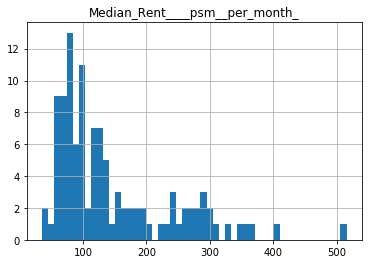

In [37]:
df.hist(column='Median_Rent____psm__per_month_', bins=50)

In [38]:
df = df.drop('gcode', axis=1)
df.head()

,Street,Median_Rent____psm__per_month_,lat,long
0,"AIRPORT BOULEVARD, sg",270.63,1.358623,103.989130
1,"ALEXANDRA ROAD, sg",102.91,1.283903,103.801557
2,"ANG MO KIO AVENUE 3, sg",303.79,1.369781,103.838831
3,"ANSON ROAD, sg",75.36,1.271805,103.843321
4,"BALESTIER ROAD, sg",76.67,1.322346,103.852741


### **Define the Kcluster=6, k-means will partition the dataset into 6 groups according to price and location.**

In [39]:
kclusters = 6

Price_grouped_clustering = df.drop('Street', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Price_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 0, 0, 3, 0, 0, 0, 4], dtype=int32)

In [40]:
df.rename(columns={'Street':'Neighborhood',}, 
                 inplace=True)

### **insert the Price Cluster Label to the dataframe**

In [41]:
df.insert(0, 'Price Cluster Label', kmeans.labels_)

In [42]:
df.head()

,Price Cluster Label,Neighborhood,Median_Rent____psm__per_month_,lat,long
0,1,"AIRPORT BOULEVARD, sg",270.63,1.358623,103.989130
1,0,"ALEXANDRA ROAD, sg",102.91,1.283903,103.801557
2,1,"ANG MO KIO AVENUE 3, sg",303.79,1.369781,103.838831
3,0,"ANSON ROAD, sg",75.36,1.271805,103.843321
4,0,"BALESTIER ROAD, sg",76.67,1.322346,103.852741


### **Merge the dataframe with Price Cluster Label with Dataframe neighborhoods_venues_sorted**

In [43]:
df1=neighborhoods_venues_sorted.merge(df,how='left', left_on='Neighborhood', right_on='Neighborhood')
df1.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,Price Cluster Label,Median_Rent____psm__per_month_,lat,long
0,"AIRPORT BOULEVARD, sg",Airport Lounge,Boutique,Public Art,Sandwich Place,Candy Store,Spa,Smoke Shop,Supermarket,General Entertainment,Garden,Bubble Tea Shop,Burger Joint,Multiplex,Snack Place,Shopping Mall,Food Court,Café,Gift Shop,Shoe Store,Fast Food Restaurant,Cocktail Bar,Coffee Shop,Ice Cream Shop,Electronics Store,Border Crossing,Dim Sum Restaurant,Hotel,Hobby Shop,Waterfall,Halal Restaurant,1,270.63,1.358623,103.989130
1,"ALEXANDRA ROAD, sg",Chinese Restaurant,Bakery,Juice Bar,Seafood Restaurant,Sporting Goods Shop,Thai Restaurant,Soup Place,Bridge,Asian Restaurant,Food Court,Satay Restaurant,Fast Food Restaurant,Dumpling Restaurant,Filipino Restaurant,Field,Fishing Spot,Fish & Chips Shop,Women's Store,Flea Market,Flower Shop,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Food,Farmers Market,Frozen Yogurt Shop,Farm,Falafel Restaurant,Event Space,0,102.91,1.283903,103.801557
2,"ANG MO KIO AVENUE 3, sg",Chinese Restaurant,Food Court,Fast Food Restaurant,Supermarket,Seafood Restaurant,General Entertainment,Vegetarian / Vegan Restaurant,Coffee Shop,Indian Restaurant,Soup Place,Noodle House,Food,Farmers Market,Food & Drink Shop,Flower Shop,Flea Market,Fishing Spot,Fish & Chips Shop,Filipino Restaurant,Food Stand,Food Truck,Field,Falafel Restaurant,Farm,Dive Bar,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,1,303.79,1.369781,103.838831
3,"ANSON ROAD, sg",Coffee Shop,Café,Japanese Restaurant,Hotel,Food Court,Salad Place,Soup Place,Soba Restaurant,Bakery,Sushi Restaurant,Supermarket,Fast Food Restaurant,Indian Restaurant,Chinese Restaurant,Bus Stop,Buffet,Spa,Furniture / Home Store,Discount Store,Pub,Cocktail Bar,Shopping Mall,Music Venue,Ramen Restaurant,Shabu-Shabu Restaurant,Restaurant,Sandwich Place,Mosque,Mediterranean Restaurant,Asian Restaurant,0,75.36,1.271805,103.843321
4,"BALESTIER ROAD, sg",Chinese Restaurant,Asian Restaurant,Indian Restaurant,Hotel,Noodle House,Food,Seafood Restaurant,Dessert Shop,Food Court,Bakery,Sculpture Garden,Grocery Store,Vietnamese Restaurant,Café,Snack Place,Fast Food Restaurant,Fruit & Vegetable Store,Vegetarian / Vegan Restaurant,Flower Shop,Flea Market,Fishing Spot,Fish & Chips Shop,Filipino Restaurant,Field,Food Stand,Food & Drink Shop,Farm,Farmers Market,French Restaurant,Falafel Restaurant,0,76.67,1.322346,103.852741


### **Again, k-means will partition the dataset into 6 groups according to Venue**

In [49]:
kclusters = 6

Venue_grouped_clustering = Street_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Venue_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 3, 0, 3, 0, 0, 0, 3, 1], dtype=int32)

In [50]:
# add clustering labels
Street_grouped.insert(0, 'Venue Cluster Label', kmeans.labels_)
Street_grouped.head()

ValueError: cannot insert Venue Cluster Label, already exists

In [51]:
df2=Street_grouped[['Venue Cluster Label','Neighborhood']]
df2.head()

,Venue Cluster Label,Neighborhood
0,0,"AIRPORT BOULEVARD, sg"
1,1,"ALEXANDRA ROAD, sg"
2,1,"ANG MO KIO AVENUE 3, sg"
3,2,"ANSON ROAD, sg"
4,1,"BALESTIER ROAD, sg"


### **Again, Merge the dataframe**

In [52]:
df3=df2.merge(df1,how='left', left_on='Neighborhood', right_on='Neighborhood')
df3.head()

,Venue Cluster Label,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,Price Cluster Label,Median_Rent____psm__per_month_,lat,long
0,0,"AIRPORT BOULEVARD, sg",Airport Lounge,Boutique,Public Art,Sandwich Place,Candy Store,Spa,Smoke Shop,Supermarket,General Entertainment,Garden,Bubble Tea Shop,Burger Joint,Multiplex,Snack Place,Shopping Mall,Food Court,Café,Gift Shop,Shoe Store,Fast Food Restaurant,Cocktail Bar,Coffee Shop,Ice Cream Shop,Electronics Store,Border Crossing,Dim Sum Restaurant,Hotel,Hobby Shop,Waterfall,Halal Restaurant,1,270.63,1.358623,103.989130
1,1,"ALEXANDRA ROAD, sg",Chinese Restaurant,Bakery,Juice Bar,Seafood Restaurant,Sporting Goods Shop,Thai Restaurant,Soup Place,Bridge,Asian Restaurant,Food Court,Satay Restaurant,Fast Food Restaurant,Dumpling Restaurant,Filipino Restaurant,Field,Fishing Spot,Fish & Chips Shop,Women's Store,Flea Market,Flower Shop,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Food,Farmers Market,Frozen Yogurt Shop,Farm,Falafel Restaurant,Event Space,0,102.91,1.283903,103.801557
2,1,"ANG MO KIO AVENUE 3, sg",Chinese Restaurant,Food Court,Fast Food Restaurant,Supermarket,Seafood Restaurant,General Entertainment,Vegetarian / Vegan Restaurant,Coffee Shop,Indian Restaurant,Soup Place,Noodle House,Food,Farmers Market,Food & Drink Shop,Flower Shop,Flea Market,Fishing Spot,Fish & Chips Shop,Filipino Restaurant,Food Stand,Food Truck,Field,Falafel Restaurant,Farm,Dive Bar,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,1,303.79,1.369781,103.838831
3,2,"ANSON ROAD, sg",Coffee Shop,Café,Japanese Restaurant,Hotel,Food Court,Salad Place,Soup Place,Soba Restaurant,Bakery,Sushi Restaurant,Supermarket,Fast Food Restaurant,Indian Restaurant,Chinese Restaurant,Bus Stop,Buffet,Spa,Furniture / Home Store,Discount Store,Pub,Cocktail Bar,Shopping Mall,Music Venue,Ramen Restaurant,Shabu-Shabu Restaurant,Restaurant,Sandwich Place,Mosque,Mediterranean Restaurant,Asian Restaurant,0,75.36,1.271805,103.843321
4,1,"BALESTIER ROAD, sg",Chinese Restaurant,Asian Restaurant,Indian Restaurant,Hotel,Noodle House,Food,Seafood Restaurant,Dessert Shop,Food Court,Bakery,Sculpture Garden,Grocery Store,Vietnamese Restaurant,Café,Snack Place,Fast Food Restaurant,Fruit & Vegetable Store,Vegetarian / Vegan Restaurant,Flower Shop,Flea Market,Fishing Spot,Fish & Chips Shop,Filipino Restaurant,Field,Food Stand,Food & Drink Shop,Farm,Farmers Market,French Restaurant,Falafel Restaurant,0,76.67,1.322346,103.852741


### **Now we rearrange the columnn order**

In [53]:
df3=df3[['Neighborhood','Venue Cluster Label','Price Cluster Label','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue','6th Most Common Venue','7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue','11th Most Common Venue','12th Most Common Venue','13th Most Common Venue','14th Most Common Venue','15th Most Common Venue','16th Most Common Venue','17th Most Common Venue','18th Most Common Venue','19th Most Common Venue','20th Most Common Venue','21th Most Common Venue','22th Most Common Venue','23th Most Common Venue','24th Most Common Venue','25th Most Common Venue','26th Most Common Venue','27th Most Common Venue','28th Most Common Venue','29th Most Common Venue','30th Most Common Venue','Median_Rent____psm__per_month_','lat','long']]

In [54]:
df3.head()

,Neighborhood,Venue Cluster Label,Price Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,Median_Rent____psm__per_month_,lat,long
0,"AIRPORT BOULEVARD, sg",0,1,Airport Lounge,Boutique,Public Art,Sandwich Place,Candy Store,Spa,Smoke Shop,Supermarket,General Entertainment,Garden,Bubble Tea Shop,Burger Joint,Multiplex,Snack Place,Shopping Mall,Food Court,Café,Gift Shop,Shoe Store,Fast Food Restaurant,Cocktail Bar,Coffee Shop,Ice Cream Shop,Electronics Store,Border Crossing,Dim Sum Restaurant,Hotel,Hobby Shop,Waterfall,Halal Restaurant,270.63,1.358623,103.989130
1,"ALEXANDRA ROAD, sg",1,0,Chinese Restaurant,Bakery,Juice Bar,Seafood Restaurant,Sporting Goods Shop,Thai Restaurant,Soup Place,Bridge,Asian Restaurant,Food Court,Satay Restaurant,Fast Food Restaurant,Dumpling Restaurant,Filipino Restaurant,Field,Fishing Spot,Fish & Chips Shop,Women's Store,Flea Market,Flower Shop,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Food,Farmers Market,Frozen Yogurt Shop,Farm,Falafel Restaurant,Event Space,102.91,1.283903,103.801557
2,"ANG MO KIO AVENUE 3, sg",1,1,Chinese Restaurant,Food Court,Fast Food Restaurant,Supermarket,Seafood Restaurant,General Entertainment,Vegetarian / Vegan Restaurant,Coffee Shop,Indian Restaurant,Soup Place,Noodle House,Food,Farmers Market,Food & Drink Shop,Flower Shop,Flea Market,Fishing Spot,Fish & Chips Shop,Filipino Restaurant,Food Stand,Food Truck,Field,Falafel Restaurant,Farm,Dive Bar,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,303.79,1.369781,103.838831
3,"ANSON ROAD, sg",2,0,Coffee Shop,Café,Japanese Restaurant,Hotel,Food Court,Salad Place,Soup Place,Soba Restaurant,Bakery,Sushi Restaurant,Supermarket,Fast Food Restaurant,Indian Restaurant,Chinese Restaurant,Bus Stop,Buffet,Spa,Furniture / Home Store,Discount Store,Pub,Cocktail Bar,Shopping Mall,Music Venue,Ramen Restaurant,Shabu-Shabu Restaurant,Restaurant,Sandwich Place,Mosque,Mediterranean Restaurant,Asian Restaurant,75.36,1.271805,103.843321
4,"BALESTIER ROAD, sg",1,0,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Hotel,Noodle House,Food,Seafood Restaurant,Dessert Shop,Food Court,Bakery,Sculpture Garden,Grocery Store,Vietnamese Restaurant,Café,Snack Place,Fast Food Restaurant,Fruit & Vegetable Store,Vegetarian / Vegan Restaurant,Flower Shop,Flea Market,Fishing Spot,Fish & Chips Shop,Filipino Restaurant,Field,Food Stand,Food & Drink Shop,Farm,Farmers Market,French Restaurant,Falafel Restaurant,76.67,1.322346,103.852741


### **Plot the map by using folium to visualization the data**

In [55]:
address = 'Singapore, SG'

geolocator = Nominatim(user_agent="CA_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapre are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapre are 1.357107, 103.8194992.


In [56]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df3['lat'], df3['long'], df3['Neighborhood'], df3['Price Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [57]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df3['lat'], df3['long'], df3['Neighborhood'], df3['Venue Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [59]:
df4=df3.loc[df3['Price Cluster Label'] == 0]

#### My friend budget is around SGD 100 per squar feet, let us filter the price cluster 1 from the dataframe

In [65]:
df4.head()

,Neighborhood,Venue Cluster Label,Price Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,Median_Rent____psm__per_month_,lat,long
1,"ALEXANDRA ROAD, sg",1,0,Chinese Restaurant,Bakery,Juice Bar,Seafood Restaurant,Sporting Goods Shop,Thai Restaurant,Soup Place,Bridge,Asian Restaurant,Food Court,Satay Restaurant,Fast Food Restaurant,Dumpling Restaurant,Filipino Restaurant,Field,Fishing Spot,Fish & Chips Shop,Women's Store,Flea Market,Flower Shop,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Food,Farmers Market,Frozen Yogurt Shop,Farm,Falafel Restaurant,Event Space,102.91,1.283903,103.801557
3,"ANSON ROAD, sg",2,0,Coffee Shop,Café,Japanese Restaurant,Hotel,Food Court,Salad Place,Soup Place,Soba Restaurant,Bakery,Sushi Restaurant,Supermarket,Fast Food Restaurant,Indian Restaurant,Chinese Restaurant,Bus Stop,Buffet,Spa,Furniture / Home Store,Discount Store,Pub,Cocktail Bar,Shopping Mall,Music Venue,Ramen Restaurant,Shabu-Shabu Restaurant,Restaurant,Sandwich Place,Mosque,Mediterranean Restaurant,Asian Restaurant,75.36,1.271805,103.843321
4,"BALESTIER ROAD, sg",1,0,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Hotel,Noodle House,Food,Seafood Restaurant,Dessert Shop,Food Court,Bakery,Sculpture Garden,Grocery Store,Vietnamese Restaurant,Café,Snack Place,Fast Food Restaurant,Fruit & Vegetable Store,Vegetarian / Vegan Restaurant,Flower Shop,Flea Market,Fishing Spot,Fish & Chips Shop,Filipino Restaurant,Field,Food Stand,Food & Drink Shop,Farm,Farmers Market,French Restaurant,Falafel Restaurant,76.67,1.322346,103.852741
6,"BEACH ROAD, sg",2,0,Thai Restaurant,Hotel,Italian Restaurant,Café,Bakery,Coffee Shop,Indonesian Restaurant,Food Court,Vietnamese Restaurant,Restaurant,French Restaurant,Tea Room,Yoga Studio,Halal Restaurant,Taiwanese Restaurant,Cocktail Bar,Burger Joint,Beer Bar,Multiplex,Pet Café,Performing Arts Venue,Hookah Bar,Indian Restaurant,Jazz Club,Art Gallery,Food & Drink Shop,Fishing Spot,Flea Market,Flower Shop,Food,74.63,1.303052,103.862267
7,"BENCOOLEN STREET, sg",2,0,Hotel,Japanese Restaurant,Café,Bakery,Ice Cream Shop,Karaoke Bar,Art Museum,Vegetarian / Vegan Restaurant,Multiplex,Clothing Store,Concert Hall,Dessert Shop,Plaza,Park,Other Repair Shop,Optical Shop,Nightclub,Museum,Italian Restaurant,Movie Theater,French Restaurant,Hobby Shop,Bubble Tea Shop,Middle Eastern Restaurant,Gaming Cafe,General Entertainment,Malay Restaurant,Gym / Fitness Center,Halal Restaurant,Mobile Phone Shop,92.00,1.297391,103.849098


#### Now we have the dataframe df4 to have all the location information that within my friends'budget'. we are going to look  into each Venue clusters

#### Venue Cluster 1

In [64]:
df4.loc[df4['Venue Cluster Label']== 0]

,Neighborhood,Venue Cluster Label,Price Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,Median_Rent____psm__per_month_,lat,long
19,"EAST COAST ROAD, sg",0,0,Noodle House,Coffee Shop,Park,Food Court,Buffet,Snack Place,Cocktail Bar,Mexican Restaurant,Bar,Bakery,Chinese Restaurant,Café,Ramen Restaurant,American Restaurant,Soup Place,Italian Restaurant,Wine Bar,Deli / Bodega,Food & Drink Shop,Food,Food Stand,Food Truck,Flower Shop,Flea Market,Fishing Spot,Fish & Chips Shop,Falafel Restaurant,Filipino Restaurant,Field,Fast Food Restaurant,65.52,1.308622,103.914990
21,"GEYLANG ROAD, sg",0,0,Chinese Restaurant,Indian Restaurant,Hotel,Seafood Restaurant,Vegetarian / Vegan Restaurant,Café,Noodle House,BBQ Joint,Dim Sum Restaurant,Kitchen Supply Store,Boarding House,Gym / Fitness Center,Climbing Gym,Farmers Market,Nightclub,Korean Restaurant,Martial Arts Dojo,Electronics Store,Supermarket,Dessert Shop,Convenience Store,Asian Restaurant,Spa,Japanese Restaurant,Soup Place,Flower Shop,Flea Market,Food & Drink Shop,Fishing Spot,Food Court,72.96,1.313109,103.882208
28,"HOUGANG STREET 51, sg",0,0,Food Court,Noodle House,Café,Breakfast Spot,Fried Chicken Joint,Park,Sandwich Place,Snack Place,Coffee Shop,General Entertainment,Indian Restaurant,Asian Restaurant,Steakhouse,Food & Drink Shop,Japanese Restaurant,Filipino Restaurant,Food,Flower Shop,Food Stand,Flea Market,Food Truck,Fishing Spot,Fish & Chips Shop,Farm,Field,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,63.48,1.377128,103.884651
29,"IRRAWADDY ROAD, sg",0,0,Chinese Restaurant,Hotel,Bakery,Asian Restaurant,Food Court,Café,Coffee Shop,Sandwich Place,Noodle House,Pharmacy,Bus Station,Supermarket,Ramen Restaurant,Fast Food Restaurant,Bar,Mediterranean Restaurant,Middle Eastern Restaurant,Monument / Landmark,Shopping Mall,Food Stand,Dessert Shop,Lighting Store,Restaurant,Park,Bistro,Burger Joint,Tea Room,Japanese Restaurant,Indian Restaurant,Italian Restaurant,102.17,1.324259,103.845926
30,"JALAN ANAK BUKIT, sg",0,0,Korean Restaurant,Chinese Restaurant,Thai Restaurant,Food Court,Café,Asian Restaurant,Coffee Shop,Dim Sum Restaurant,Bakery,Supermarket,Dessert Shop,Seafood Restaurant,Shopping Mall,Hainan Restaurant,Indian Restaurant,Pizza Place,Sandwich Place,Convenience Store,Diner,Pet Store,Fast Food Restaurant,Noodle House,Fried Chicken Joint,General Entertainment,Massage Studio,Grocery Store,Soup Place,Ice Cream Shop,Beer Store,BBQ Joint,81.85,1.341203,103.778077
31,"JALAN BERSEH, sg",0,0,Indian Restaurant,Chinese Restaurant,Café,Hotel,Hostel,Food Court,Dumpling Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Dessert Shop,Dim Sum Restaurant,Bakery,Italian Restaurant,North Indian Restaurant,Plaza,Shopping Mall,Frozen Yogurt Shop,Bubble Tea Shop,Southern / Soul Food Restaurant,Fried Chicken Joint,Soup Place,Park,Snack Place,Department Store,Burrito Place,Mediterranean Restaurant,Seafood Restaurant,Noodle House,Discount Store,Motorcycle Shop,62.72,1.307518,103.857185
32,"JALAN BESAR, sg",0,0,Indian Restaurant,Café,Food Court,Bakery,Chinese Restaurant,Halal Restaurant,Steakhouse,Mediterranean Restaurant,Motorcycle Shop,Snack Place,Yoga Studio,Thai Restaurant,Ramen Restaurant,Dive Bar,Pub,Dim Sum Restaurant,Pet Café,Noodle House,Gaming Cafe,Hostel,Vietnamese Restaurant,Toy / Game Store,Accessories Store,Vegetarian / Vegan Restauran

#### Venue Cluster 2

In [67]:
df4.loc[df4['Venue Cluster Label']== 1]

,Neighborhood,Venue Cluster Label,Price Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,Median_Rent____psm__per_month_,lat,long
1,"ALEXANDRA ROAD, sg",1,0,Chinese Restaurant,Bakery,Juice Bar,Seafood Restaurant,Sporting Goods Shop,Thai Restaurant,Soup Place,Bridge,Asian Restaurant,Food Court,Satay Restaurant,Fast Food Restaurant,Dumpling Restaurant,Filipino Restaurant,Field,Fishing Spot,Fish & Chips Shop,Women's Store,Flea Market,Flower Shop,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Food,Farmers Market,Frozen Yogurt Shop,Farm,Falafel Restaurant,Event Space,102.91,1.283903,103.801557
4,"BALESTIER ROAD, sg",1,0,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Hotel,Noodle House,Food,Seafood Restaurant,Dessert Shop,Food Court,Bakery,Sculpture Garden,Grocery Store,Vietnamese Restaurant,Café,Snack Place,Fast Food Restaurant,Fruit & Vegetable Store,Vegetarian / Vegan Restaurant,Flower Shop,Flea Market,Fishing Spot,Fish & Chips Shop,Filipino Restaurant,Field,Food Stand,Food & Drink Shop,Farm,Farmers Market,French Restaurant,Falafel Restaurant,76.67,1.322346,103.852741
8,"BUKIT TIMAH ROAD, sg",1,0,Chinese Restaurant,Seafood Restaurant,Café,Gym,Shopping Mall,Bakery,Flower Shop,Hospital,Asian Restaurant,Dance Studio,Noodle House,Food Court,Bus Line,Wine Bar,Kids Store,Food & Drink Shop,Food,Food Stand,Flea Market,Fishing Spot,Fish & Chips Shop,Food Truck,Filipino Restaurant,Farmers Market,Field,Fast Food Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,96.15,1.310848,103.843804
10,"CHANGI ROAD, sg",1,0,Chinese Restaurant,Indian Restaurant,Food Court,Seafood Restaurant,BBQ Joint,Shopping Mall,Gas Station,Juice Bar,Asian Restaurant,Noodle House,Malay Restaurant,Train Station,Gym / Fitness Center,Coffee Shop,Bar,French Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Stand,Fishing Spot,Flea Market,Food Truck,Food,Food & Drink Shop,Flower Shop,Farmers Market,Field,Drugstore,Dim Sum Restaurant,Diner,63.07,1.318717,103.910811
34,"JALAN MASJID, sg",1,0,Chinese Restaurant,Indian Restaurant,Train Station,Asian Restaurant,Seafood Restaurant,Gym / Fitness Center,Shopping Mall,Coffee Shop,Gastropub,BBQ Joint,Gas Station,Noodle House,Juice Bar,Food Court,Food,Field,Food Stand,Flower Shop,Flea Market,Fishing Spot,Fish & Chips Shop,Filipino Restaurant,Food & Drink Shop,Food Truck,Farmers Market,Fast Food Restaurant,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,35.65,1.319684,103.912464
43,"MACPHERSON ROAD, sg",1,0,Chinese Restaurant,Food Court,Furniture / Home Store,Asian Restaurant,Steakhouse,Gas Station,Noodle House,Café,Coffee Shop,Sporting Goods Shop,Indian Restaurant,Ice Cream Shop,Dog Run,Fishing Spot,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Dessert Shop,Dim Sum Restaurant,Food & Drink Shop,Food,Flower Shop,Diner,Flea Market,Fish & Chips Shop,Donut Shop,Filipino Restaurant,Field,Fast Food Restaurant,81.97,1.329165,103.872555
59,"QUEENSWAY, sg",1,0,Chinese Restaurant,Asian Restaurant,Noodle House,Ice Cream Shop,Coffee Shop,Pool,Food Court,Food & Drink Shop,Stadium,Supermarket,Market,Malay Restaurant,Falafel Restaurant,Basketball Court,Fried Chicken Joint,ATM,Diner,Indian Restaurant,Vegetarian / Vegan Restaurant,Pharmacy,Dumpling Restaurant,Fishing Spot,French Restaurant,Food Truck,Food Stand,Dim Sum Restaurant,Food,Flower Shop,Discount Store,Flea Mark

#### Venue Cluster 3

In [68]:
df4.loc[df4['Venue Cluster Label']== 2]

,Neighborhood,Venue Cluster Label,Price Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,Median_Rent____psm__per_month_,lat,long
3,"ANSON ROAD, sg",2,0,Coffee Shop,Café,Japanese Restaurant,Hotel,Food Court,Salad Place,Soup Place,Soba Restaurant,Bakery,Sushi Restaurant,Supermarket,Fast Food Restaurant,Indian Restaurant,Chinese Restaurant,Bus Stop,Buffet,Spa,Furniture / Home Store,Discount Store,Pub,Cocktail Bar,Shopping Mall,Music Venue,Ramen Restaurant,Shabu-Shabu Restaurant,Restaurant,Sandwich Place,Mosque,Mediterranean Restaurant,Asian Restaurant,75.36,1.271805,103.843321
6,"BEACH ROAD, sg",2,0,Thai Restaurant,Hotel,Italian Restaurant,Café,Bakery,Coffee Shop,Indonesian Restaurant,Food Court,Vietnamese Restaurant,Restaurant,French Restaurant,Tea Room,Yoga Studio,Halal Restaurant,Taiwanese Restaurant,Cocktail Bar,Burger Joint,Beer Bar,Multiplex,Pet Café,Performing Arts Venue,Hookah Bar,Indian Restaurant,Jazz Club,Art Gallery,Food & Drink Shop,Fishing Spot,Flea Market,Flower Shop,Food,74.63,1.303052,103.862267
7,"BENCOOLEN STREET, sg",2,0,Hotel,Japanese Restaurant,Café,Bakery,Ice Cream Shop,Karaoke Bar,Art Museum,Vegetarian / Vegan Restaurant,Multiplex,Clothing Store,Concert Hall,Dessert Shop,Plaza,Park,Other Repair Shop,Optical Shop,Nightclub,Museum,Italian Restaurant,Movie Theater,French Restaurant,Hobby Shop,Bubble Tea Shop,Middle Eastern Restaurant,Gaming Cafe,General Entertainment,Malay Restaurant,Gym / Fitness Center,Halal Restaurant,Mobile Phone Shop,92.00,1.297391,103.849098
13,"CLEMENCEAU AVENUE, sg",2,0,Japanese Restaurant,Hotel,Café,Coffee Shop,Seafood Restaurant,Steakhouse,BBQ Joint,Mexican Restaurant,Nightclub,Italian Restaurant,Hotpot Restaurant,Bubble Tea Shop,Pub,Dim Sum Restaurant,Thai Restaurant,Bar,Gym,Wine Bar,Food Court,Sandwich Place,Sake Bar,Restaurant,Persian Restaurant,Residential Building (Apartment / Condo),Ramen Restaurant,Hotel Bar,Shopping Mall,Cocktail Bar,Pizza Place,Dessert Shop,76.34,1.288650,103.841407
14,"COLEMAN STREET, sg",2,0,Hotel,Japanese Restaurant,Art Gallery,Shopping Mall,French Restaurant,Supermarket,Market,Lounge,Spa,Soup Place,Business Service,Café,Gym / Fitness Center,Seafood Restaurant,River,Restaurant,Club House,Coffee Shop,Concert Hall,Bistro,Park,Event Space,Museum,Lighthouse,Modern European Restaurant,Plaza,Yoga Studio,Waterfront,Vegetarian / Vegan Restaurant,Bike Rental / Bike Share,74.99,1.292480,103.849637
17,"CUPPAGE ROAD, sg",2,0,Clothing Store,Shopping Mall,Hotel,Japanese Restaurant,Chinese Restaurant,Spa,Wine Bar,Park,Shoe Store,Bistro,Swiss Restaurant,Supermarket,Mexican Restaurant,Food Court,Discount Store,Filipino Restaurant,Hotpot Restaurant,Noodle House,Tea Room,Coffee Shop,Pool,Electronics Store,Dumpling Restaurant,Hainan Restaurant,Department Store,Beer Garden,Bakery,Hotel Bar,American Restaurant,Italian Restaurant,73.33,1.301689,103.840319
18,"CUSCADEN ROAD, sg",2,0,Hotel,Bus Station,Indian Restaurant,Cocktail Bar,Spa,Supermarket,Lounge,Bar,Korean Restaurant,Deli / Bodega,Asian Restaurant,Japanese Restaurant,Italian Restaurant,Art Gallery,Food,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food & Drink Shop,Field,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Ice Cream Shop,Filipino Restaurant,Hotel Bar,Fast Food Restaurant,62.43,1.304027,103.823818
20,"EU TONG SEN STREET, sg",2,0,Café,Italian Re

#### Venue Cluster 4

In [69]:
df4.loc[df4['Venue Cluster Label']== 3]

,Neighborhood,Venue Cluster Label,Price Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,Median_Rent____psm__per_month_,lat,long
88,"TANGLIN ROAD, sg",3,0,Restaurant,Nightclub,Bus Line,Mexican Restaurant,Women's Store,Food,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food Court,Food & Drink Shop,Fast Food Restaurant,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Field,Farmers Market,Fruit & Vegetable Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donut Shop,Farm,96.55,1.296696,103.816509


#### Venue Cluster 6

In [71]:
df4.loc[df4['Venue Cluster Label']== 5]

,Neighborhood,Venue Cluster Label,Price Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,Median_Rent____psm__per_month_,lat,long
106,"YISHUN AVENUE 9, sg",5,0,Coffee Shop,Vegetarian / Vegan Restaurant,College Bookstore,Shopping Mall,Asian Restaurant,Thai Restaurant,Food Court,Food Stand,Food & Drink Shop,Food Truck,Fast Food Restaurant,French Restaurant,Food,Flower Shop,Flea Market,Fishing Spot,Fish & Chips Shop,Filipino Restaurant,Field,Fried Chicken Joint,Women's Store,Falafel Restaurant,Farmers Market,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,90.91,1.434035,103.841907


#### Venue Cluster 5 (no data in this cluster)

In [72]:
df4.loc[df4['Venue Cluster Label']== 4]

,Neighborhood,Venue Cluster Label,Price Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,Median_Rent____psm__per_month_,lat,long
